# 基于 Bi-directional LSTM 的序列标注任务（分词）
@author: huangyongye <br/>
@creat_date: 2017-04-19 <br/>

本例子主要参考[【中文分词系列】 4. 基于双向LSTM的seq2seq字标注]{url: http://spaces.ac.cn/archives/3924/} 这篇文章。<br/>
该文章用的是 keras 实现的双端 LSTM，在本例中，实现思路和该文章基本上一样，只是用 TensorFlow 来实现的。<br/>

本例最主要的是说明基于 TensorFlow 如何来实现 Bi-LSTM。在后面部分进行最后分词处理用的是维特比译码，如果想了解为什么的话可以看一下《统计学习方法》第10章介绍的隐马尔可夫模型。

主要参考: <br/>
[1] 【中文分词系列】 4. 基于双向LSTM的seq2seq字标注 http://spaces.ac.cn/archives/3924/  <br/>
[2] https://github.com/yongyehuang/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/bidirectional_rnn.py  <br/>
[3] https://github.com/yongyehuang/deepnlp/blob/master/deepnlp/pos/pos_model_bilstm.py

In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## 1. 数据预处理

In [2]:
# 以字符串的形式读入所有数据
with open('raw_data/msr_train.txt', 'rb') as inp:
    texts = inp.read().decode('gbk')
# 根据换行切分
sentences = texts.split('\r\n')  # 根据换行切分成

# 将不规范的内容（如每行的开头）去掉
def clean(s): 
    if u'“/s' not in s:  # 句子中间的引号不应去掉
        return s.replace(u' ”/s', '')
    elif u'”/s' not in s:
        return s.replace(u'“/s ', '')
    elif u'‘/s' not in s:
        return s.replace(u' ’/s', '')
    elif u'’/s' not in s:
        return s.replace(u'‘/s ', '')
    else:
        return s
    
texts = u''.join(map(clean, sentences)) # 把所有的词拼接起来
print 'Length of texts is %d' % len(texts)
print 'Example of texts: \n', texts[:300]

Length of texts is 20339269
Example of texts: 
“/s  人/b  们/e  常/s  说/s  生/b  活/e  是/s  一/s  部/s  教/b  科/m  书/e  ，/s  而/s  血/s  与/s  火/s  的/s  战/b  争/e  更/s  是/s  不/b  可/m  多/m  得/e  的/s  教/b  科/m  书/e  ，/s  她/s  确/b  实/e  是/s  名/b  副/m  其/m  实/e  的/s  ‘/s  我/s  的/s  大/b  学/e  ’/s  。/s  
“/s  心/s  静/s  渐/s  知/s  春/s  似/s  海/s  ，/s  花/s  深/s  每/s 


In [3]:
# 重新以标点来划分
sentences = re.split(u'[，。！？、‘’“”]/[bems]', texts)
print 'Sentences number:', len(sentences)
print 'Sentence Example:\n', sentences[0]

Sentences number: 332856
Sentence Example:



In [4]:
def get_Xy(sentence):
    """将 sentence 处理成 [word1, w2, ..wn], [tag1, t2, ...tn]"""
    words_tags = re.findall('(.)/(.)', sentence)
    if words_tags:
        words_tags = np.asarray(words_tags)
        words = words_tags[:, 0]
        tags = words_tags[:, 1]
        return words, tags # 所有的字和tag分别存为 data / label
    return None

datas = list()
labels = list()
print 'Start creating words and tags data ...'
for sentence in tqdm(iter(sentences)):
    result = get_Xy(sentence)
    if result:
        datas.append(result[0])
        labels.append(result[1])

print 'Length of datas is %d' % len(datas) 
print 'Example of datas: ', datas[0]
print 'Example of labels:', labels[0]

6078it [00:00, 60773.25it/s]

Start creating words and tags data ...


332856it [00:03, 83424.89it/s]

Length of datas is 321827
Example of datas:  [u'\u4eba' u'\u4eec' u'\u5e38' u'\u8bf4' u'\u751f' u'\u6d3b' u'\u662f'
 u'\u4e00' u'\u90e8' u'\u6559' u'\u79d1' u'\u4e66']
Example of labels: [u'b' u'e' u's' u's' u'b' u'e' u's' u's' u's' u'b' u'm' u'e']


In [5]:
df_data = pd.DataFrame({'words': datas, 'tags': labels}, index=range(len(datas)))
#　句子长度
df_data['sentence_len'] = df_data['words'].apply(lambda words: len(words))
df_data.head(2)

,tags,words,sentence_len
0,"[b, e, s, s, b, e, s, s, s, b, m, e]","[人, 们, 常, 说, 生, 活, 是, 一, 部, 教, 科, 书]",12
1,"[s, s, s, s, s, b, e, s, s, b, m, m, e, s, b, ...","[而, 血, 与, 火, 的, 战, 争, 更, 是, 不, 可, 多, 得, 的, 教, ...",17


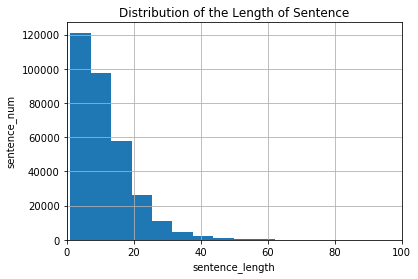

In [6]:
# 句子长度的分布
import matplotlib.pyplot as plt
df_data['sentence_len'].hist(bins=100)
plt.xlim(0, 100)
plt.xlabel('sentence_length')
plt.ylabel('sentence_num')
plt.title('Distribution of the Length of Sentence')
plt.show()

从上图可以看到，在使用标点进行分割后，绝大部分的句子长度小于30个字。因为一般情况下，我们训练网络的时候都喜欢把输入 padding 到固定的长度，这样子计算更快。因此我们取 32 作为句子长度，超过 32 个字的将把多余的字去掉，少于 32 个字的将用特殊字符填充。

In [7]:
# 1.用 chain(*lists) 函数把多个list拼接起来
from itertools import chain
all_words = list(chain(*df_data['words'].values))
# 2.统计所有 word
sr_allwords = pd.Series(all_words)
sr_allwords = sr_allwords.value_counts()
set_words = sr_allwords.index
set_ids = range(1, len(set_words)+1) # 注意从1开始，因为我们准备把0作为填充值
tags = [ 'x', 's', 'b', 'm', 'e']
tag_ids = range(len(tags))

# 3. 构建 words 和 tags 都转为数值 id 的映射（使用 Series 比 dict 更加方便）
word2id = pd.Series(set_ids, index=set_words)
id2word = pd.Series(set_words, index=set_ids)
tag2id = pd.Series(tag_ids, index=tags)
id2tag = pd.Series(tags, index=tag_ids)

In [8]:
vocab_size = len(set_words)
print 'vocab_size={}'.format(vocab_size)

vocab_size=5158


把 words 和 tags 都转为数值 id

In [9]:
max_len = 32
def X_padding(words):
    """把 words 转为 id 形式，并自动补全位 max_len 长度。"""
    ids = list(word2id[words])
    if len(ids) >= max_len:  # 长则弃掉
        return ids[:max_len]
    ids.extend([0]*(max_len-len(ids))) # 短则补全
    return ids

def y_padding(tags):
    """把 tags 转为 id 形式， 并自动补全位 max_len 长度。"""
    ids = list(tag2id[tags])
    if len(ids) >= max_len:  # 长则弃掉
        return ids[:max_len]
    ids.extend([0]*(max_len-len(ids))) # 短则补全
    return ids

%time df_data['X'] = df_data['words'].apply(X_padding)
%time df_data['y'] = df_data['tags'].apply(y_padding)

CPU times: user 2min 10s, sys: 1.07 s, total: 2min 11s
Wall time: 2min 9s
CPU times: user 2min 5s, sys: 1.42 s, total: 2min 6s
Wall time: 2min 4s


In [10]:
# 最后得到了所有的数据
X = np.asarray(list(df_data['X'].values))
y = np.asarray(list(df_data['y'].values))
print 'X.shape={}, y.shape={}'.format(X.shape, y.shape)
print 'Example of words: ', df_data['words'].values[0]
print 'Example of X: ', X[0]
print 'Example of tags: ', df_data['tags'].values[0]
print 'Example of y: ', y[0]

X.shape=(321827, 32), y.shape=(321827, 32)
Example of words:  [u'\u4eba' u'\u4eec' u'\u5e38' u'\u8bf4' u'\u751f' u'\u6d3b' u'\u662f'
 u'\u4e00' u'\u90e8' u'\u6559' u'\u79d1' u'\u4e66']
Example of X:  [  8  43 320  88  36 198   7   2  41 163 124 245   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Example of tags:  [u'b' u'e' u's' u's' u'b' u'e' u's' u's' u's' u'b' u'm' u'e']
Example of y:  [2 4 1 1 2 4 1 1 1 2 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
# 保存数据
import pickle
import os

if not os.path.exists('data/'):
    os.makedirs('data/')

with open('data/data.pkl', 'wb') as outp:
    %time pickle.dump(X, outp)
    %time pickle.dump(y, outp)
    pickle.dump(word2id, outp)
    pickle.dump(id2word, outp)
    pickle.dump(tag2id, outp)
    pickle.dump(id2tag, outp)
print '** Finished saving the data.'    

CPU times: user 6.72 s, sys: 344 ms, total: 7.06 s
Wall time: 6.97 s
CPU times: user 6.8 s, sys: 268 ms, total: 7.06 s
Wall time: 6.97 s
** Finished saving the data.


In [12]:
# 导入数据
import pickle
with open('data/data.pkl', 'rb') as inp:
    %time X = pickle.load(inp)
    %time y = pickle.load(inp)
    word2id = pickle.load(inp)
    id2word = pickle.load(inp)
    tag2id = pickle.load(inp)
    id2tag = pickle.load(inp)

# 划分测试集/训练集/验证集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,  test_size=0.2, random_state=42)
print 'X_train.shape={}, y_train.shape={}; \nX_valid.shape={}, y_valid.shape={};\nX_test.shape={}, y_test.shape={}'.format(
    X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

CPU times: user 1.6 s, sys: 160 ms, total: 1.76 s
Wall time: 1.73 s
CPU times: user 1.35 s, sys: 156 ms, total: 1.5 s
Wall time: 1.48 s
X_train.shape=(205968, 32), y_train.shape=(205968, 32); 
X_valid.shape=(51493, 32), y_valid.shape=(51493, 32);
X_test.shape=(64366, 32), y_test.shape=(64366, 32)


## 2. 构造一个生成batch数据的类

In [13]:
# ** 3.build the data generator
class BatchGenerator(object):
    """ Construct a Data generator. The input X, y should be ndarray or list like type.
    
    Example:
        Data_train = BatchGenerator(X=X_train_all, y=y_train_all, shuffle=False)
        Data_test = BatchGenerator(X=X_test_all, y=y_test_all, shuffle=False)
        X = Data_train.X
        y = Data_train.y
        or:
        X_batch, y_batch = Data_train.next_batch(batch_size)
     """ 
    
    def __init__(self, X, y, shuffle=False):
        if type(X) != np.ndarray:
            X = np.asarray(X)
        if type(y) != np.ndarray:
            y = np.asarray(y)
        self._X = X
        self._y = y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._number_examples = self._X.shape[0]
        self._shuffle = shuffle
        if self._shuffle:
            new_index = np.random.permutation(self._number_examples)
            self._X = self._X[new_index]
            self._y = self._y[new_index]
                
    @property
    def X(self):
        return self._X
    
    @property
    def y(self):
        return self._y
    
    @property
    def num_examples(self):
        return self._number_examples
    
    @property
    def epochs_completed(self):
        return self._epochs_completed
    
    def next_batch(self, batch_size):
        """ Return the next 'batch_size' examples from this data set."""
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._number_examples:
            # finished epoch
            self._epochs_completed += 1
            # Shuffle the data 
            if self._shuffle:
                new_index = np.random.permutation(self._number_examples)
                self._X = self._X[new_index]
                self._y = self._y[new_index]
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._number_examples
        end = self._index_in_epoch
        return self._X[start:end], self._y[start:end]

print 'Creating the data generator ...'
data_train = BatchGenerator(X_train, y_train, shuffle=True)
data_valid = BatchGenerator(X_valid, y_valid, shuffle=False)
data_test = BatchGenerator(X_test, y_test, shuffle=False)
print 'Finished creating the data generator.'

Creating the data generator ...
Finished creating the data generator.


## 3. Bi-directional lstm 模型

### 3.1 模型构造

In [14]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from tensorflow.contrib import rnn
import numpy as np

'''
For Chinese word segmentation.
'''
# ##################### config ######################
decay = 0.85
max_epoch = 5
max_max_epoch = 10
timestep_size = max_len = 32           # 句子长度
vocab_size = 5159    # 样本中不同字的个数+1(padding 0)，根据处理数据的时候得到
input_size = embedding_size = 64       # 字向量长度
class_num = 5
hidden_size = 128    # 隐含层节点数
layer_num = 2        # bi-lstm 层数
max_grad_norm = 5.0  # 最大梯度（超过此值的梯度将被裁剪）

lr = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)
batch_size = tf.placeholder(tf.int32)  # 注意类型必须为 tf.int32
model_save_path = 'ckpt/bi-lstm.ckpt'  # 模型保存位置


def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


X_inputs = tf.placeholder(tf.int32, [None, timestep_size], name='X_input')
y_inputs = tf.placeholder(tf.int32, [None, timestep_size], name='y_input')    

def lstm_cell():
    cell = rnn.LSTMCell(hidden_size, reuse=tf.get_variable_scope().reuse)
    return rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    
def bi_lstm(X_inputs):
    """build the bi-LSTMs network. Return the y_pred"""
    # ** 0.char embedding
    embedding = tf.get_variable("embedding", [vocab_size, embedding_size], dtype=tf.float32)
    # X_inputs.shape = [batchsize, timestep_size]  ->  inputs.shape = [batchsize, timestep_size, embedding_size]
    inputs = tf.nn.embedding_lookup(embedding, X_inputs)  
    
    # ** 1.构建前向后向多层 LSTM
    cell_fw = rnn.MultiRNNCell([lstm_cell() for _ in range(layer_num)], state_is_tuple=True)
    cell_bw = rnn.MultiRNNCell([lstm_cell() for _ in range(layer_num)], state_is_tuple=True)
  
    # ** 2.初始状态
    initial_state_fw = cell_fw.zero_state(batch_size, tf.float32)
    initial_state_bw = cell_bw.zero_state(batch_size, tf.float32)  
    
    # 下面两部分是等价的
    # **************************************************************
    # ** 把 inputs 处理成 rnn.static_bidirectional_rnn 的要求形式
    # ** 文档说明
    # inputs: A length T list of inputs, each a tensor of shape
    # [batch_size, input_size], or a nested tuple of such elements.
    # *************************************************************
    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    # inputs.shape = [batchsize, timestep_size, embedding_size]  ->  timestep_size tensor, each_tensor.shape = [batchsize, embedding_size]
    # inputs = tf.unstack(inputs, timestep_size, 1)
    # ** 3.bi-lstm 计算（tf封装）  一般采用下面 static_bidirectional_rnn 函数调用。
    #   但是为了理解计算的细节，所以把后面的这段代码进行展开自己实现了一遍。
#     try:
#         outputs, _, _ = rnn.static_bidirectional_rnn(cell_fw, cell_bw, inputs, 
#                         initial_state_fw = initial_state_fw, initial_state_bw = initial_state_bw, dtype=tf.float32)
#     except Exception: # Old TensorFlow version only returns outputs not states
#         outputs = rnn.static_bidirectional_rnn(cell_fw, cell_bw, inputs, 
#                         initial_state_fw = initial_state_fw, initial_state_bw = initial_state_bw, dtype=tf.float32)
#     output = tf.reshape(tf.concat(outputs, 1), [-1, hidden_size * 2])
    # ***********************************************************
    
    # ***********************************************************
    # ** 3. bi-lstm 计算（展开）
    with tf.variable_scope('bidirectional_rnn'):
        # *** 下面，两个网络是分别计算 output 和 state 
        # Forward direction
        outputs_fw = list()
        state_fw = initial_state_fw
        with tf.variable_scope('fw'):
            for timestep in range(timestep_size):
                if timestep > 0:
                    tf.get_variable_scope().reuse_variables()
                (output_fw, state_fw) = cell_fw(inputs[:, timestep, :], state_fw)
                outputs_fw.append(output_fw)
        
        # backward direction
        outputs_bw = list()
        state_bw = initial_state_bw
        with tf.variable_scope('bw') as bw_scope:
            inputs = tf.reverse(inputs, [1])
            for timestep in range(timestep_size):
                if timestep > 0:
                    tf.get_variable_scope().reuse_variables()
                (output_bw, state_bw) = cell_bw(inputs[:, timestep, :], state_bw)
                outputs_bw.append(output_bw)
        # *** 然后把 output_bw 在 timestep 维度进行翻转
        # outputs_bw.shape = [timestep_size, batch_size, hidden_size]
        outputs_bw = tf.reverse(outputs_bw, [0])
        # 把两个oupputs 拼成 [timestep_size, batch_size, hidden_size*2]
        output = tf.concat([outputs_fw, outputs_bw], 2)
        output = tf.transpose(output, perm=[1,0,2])
        output = tf.reshape(output, [-1, hidden_size*2])
    # ***********************************************************
    
    softmax_w = weight_variable([hidden_size * 2, class_num]) 
    softmax_b = bias_variable([class_num]) 
    logits = tf.matmul(output, softmax_w) + softmax_b
    return logits


y_pred = bi_lstm(X_inputs)
# adding extra statistics to monitor
# y_inputs.shape = [batch_size, timestep_size]
correct_prediction = tf.equal(tf.cast(tf.argmax(y_pred, 1), tf.int32), tf.reshape(y_inputs, [-1]))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = tf.reshape(y_inputs, [-1]), logits = y_pred))

# ***** 优化求解 *******
# 获取模型的所有参数
tvars = tf.trainable_variables()
# 获取损失函数对于每个参数的梯度
grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), max_grad_norm)
# 优化器
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
# 梯度下降计算
train_op = optimizer.apply_gradients( zip(grads, tvars),
    global_step=tf.contrib.framework.get_or_create_global_step())
print 'Finished creating the bi-lstm model.'

Finished creating the bi-lstm model.


### 模型训练

In [ ]:
def test_epoch(dataset):
    """Testing or valid."""
    _batch_size = 5000
    fetches = [accuracy, cost]
    _y = dataset.y
    data_size = _y.shape[0]
    batch_num = int(data_size / _batch_size)
    start_time = time.time()
    _costs = 0.0
    _accs = 0.0
    for i in xrange(batch_num):
        X_batch, y_batch = dataset.next_batch(_batch_size)
        feed_dict = {X_inputs:X_batch, y_inputs:y_batch, lr:1e-5, batch_size:_batch_size, keep_prob:1.0}
        _acc, _cost = sess.run(fetches, feed_dict)
        _accs += _acc
        _costs += _cost    
    mean_acc= _accs / batch_num     
    mean_cost = _costs / batch_num
    return mean_acc, mean_cost


sess.run(tf.global_variables_initializer())
tr_batch_size = 128 
max_max_epoch = 12
display_num = 5  # 每个 epoch 显示是个结果
tr_batch_num = int(data_train.y.shape[0] / tr_batch_size)  # 每个 epoch 中包含的 batch 数
display_batch = int(tr_batch_num / display_num)  # 每训练 display_batch 之后输出一次
saver = tf.train.Saver(max_to_keep=10)  # 最多保存的模型数量
for epoch in xrange(max_max_epoch):
    _lr = 1e-4
    if epoch > max_epoch:
        _lr = _lr * ((decay) ** (epoch - max_epoch))
    print 'EPOCH %d， lr=%g' % (epoch+1, _lr)
    start_time = time.time()
    _costs = 0.0
    _accs = 0.0
    show_accs = 0.0
    show_costs = 0.0
    for batch in xrange(tr_batch_num): 
        fetches = [accuracy, cost, train_op]
        X_batch, y_batch = data_train.next_batch(tr_batch_size)
        feed_dict = {X_inputs:X_batch, y_inputs:y_batch, lr:_lr, batch_size:tr_batch_size, keep_prob:0.5}
        _acc, _cost, _ = sess.run(fetches, feed_dict) # the cost is the mean cost of one batch
        _accs += _acc
        _costs += _cost
        show_accs += _acc
        show_costs += _cost
        if (batch + 1) % display_batch == 0:
            valid_acc, valid_cost = test_epoch(data_valid)  # valid
            print '\ttraining acc=%g, cost=%g;  valid acc= %g, cost=%g ' % (show_accs / display_batch,
                                                show_costs / display_batch, valid_acc, valid_cost)
            show_accs = 0.0
            show_costs = 0.0
    mean_acc = _accs / tr_batch_num 
    mean_cost = _costs / tr_batch_num
    if (epoch + 1) % 3 == 0:  # 每 3 个 epoch 保存一次模型
        save_path = saver.save(sess, model_save_path, global_step=(epoch+1))
        print 'the save path is ', save_path
    print '\ttraining %d, acc=%g, cost=%g ' % (data_train.y.shape[0], mean_acc, mean_cost)
    print 'Epoch training %d, acc=%g, cost=%g, speed=%g s/epoch' % (data_train.y.shape[0], mean_acc, mean_cost, time.time()-start_time)        
# testing
print '**TEST RESULT:'
test_acc, test_cost = test_epoch(data_test)
print '**Test %d, acc=%g, cost=%g' % (data_test.y.shape[0], test_acc, test_cost) 

EPOCH 1， lr=0.0001
	training acc=0.704386, cost=0.783555;  valid acc= 0.755547, cost=0.539662 
	training acc=0.758313, cost=0.517217;  valid acc= 0.771606, cost=0.477238 
	training acc=0.776471, cost=0.473035;  valid acc= 0.789289, cost=0.447375 
	training acc=0.79072, cost=0.446721;  valid acc= 0.796037, cost=0.43127 
	training acc=0.798101, cost=0.430722;  valid acc= 0.799795, cost=0.423182 
	training 205968, acc=0.765687, cost=0.529987 
Epoch training 205968, acc=0.765687, cost=0.529987, speed=119.55 s/epoch
EPOCH 2， lr=0.0001
	training acc=0.801562, cost=0.421894;  valid acc= 0.810264, cost=0.405717 
	training acc=0.818577, cost=0.39991;  valid acc= 0.840292, cost=0.373497 
	training acc=0.847394, cost=0.362456;  valid acc= 0.872802, cost=0.324278 
	training acc=0.881668, cost=0.308457;  valid acc= 0.897994, cost=0.269904 
	training acc=0.897904, cost=0.271949;  valid acc= 0.906724, cost=0.247328 
	training 205968, acc=0.84954, cost=0.352727 
Epoch training 205968, acc=0.84954, cos

模型测试，现在给定一个字符串，首先应该把处理成正确的模型输入形式。即每次输入一个片段，（这里限制了每个片段的长度不超过 max_len=32）。每个字处理为对应的 id， 每个片段都会 padding 处理到固定的长度。也就是说，输入的是一个list， list 的每个元素是一个包含多个 id 的list。<br/>
即 [[id0, id1, ..., id31], [id0, id1, ..., id31], [], ...]

In [15]:
# ** 导入模型
saver = tf.train.Saver()
best_model_path = 'ckpt/bi-lstm.ckpt-12'
%time saver.restore(sess, best_model_path)

INFO:tensorflow:Restoring parameters from ckpt/bi-lstm.ckpt-12
CPU times: user 852 ms, sys: 220 ms, total: 1.07 s
Wall time: 947 ms


In [16]:
# 再看看模型的输入数据形式, 我们要进行分词，首先就要把句子转为这样的形式
X_tt, y_tt = data_train.next_batch(2)
print 'X_tt.shape=', X_tt.shape, 'y_tt.shape=', y_tt.shape
print 'X_tt = ', X_tt
print 'y_tt = ', y_tt

X_tt.shape= (2, 32) y_tt.shape= (2, 32)
X_tt =  [[ 225   87    3  330   44  912   96    8  197   59  284  174  349   48
   152  124  708 1069  170  148  408  330   44   72 1388   28  775   12
   277 1390 1657    0]
 [  58  407    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0]]
y_tt =  [[2 3 3 3 3 4 1 2 3 3 4 2 4 2 4 2 3 4 1 2 4 2 4 2 4 2 4 1 1 2 4 0]
 [2 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## 维特比解码
下面使用维特比的方法来计算的最优的状态序列。具体原理可以参考 隐马尔可夫模型。在 HMM 监督学习中，我们统计样本频数来得到转移概率和 

In [17]:
# 利用 labels（即状态序列）来统计转移概率
# 因为状态数比较少，这里用 dict={'I_tI_{t+1}'：p} 来实现
# A统计状态转移的频数
A = {
      'sb':0,
      'ss':0,
      'be':0,
      'bm':0,
      'me':0,
      'mm':0,
      'eb':0,
      'es':0
     }

# zy 表示转移概率矩阵
zy = dict()
for label in labels:
    for t in xrange(len(label) - 1):
        key = label[t] + label[t+1]
        A[key] += 1.0
        
zy['sb'] = A['sb'] / (A['sb'] + A['ss'])
zy['ss'] = 1.0 - zy['sb']
zy['be'] = A['be'] / (A['be'] + A['bm'])
zy['bm'] = 1.0 - zy['be']
zy['me'] = A['me'] / (A['me'] + A['mm'])
zy['mm'] = 1.0 - zy['me']
zy['eb'] = A['eb'] / (A['eb'] + A['es'])
zy['es'] = 1.0 - zy['eb']
keys = sorted(zy.keys())
print 'the transition probability: '
for key in keys:
    print key, zy[key]
    
zy = {i:np.log(zy[i]) for i in zy.keys()}

the transition probability: 
be 0.828739514282
bm 0.171260485718
eb 0.592369623847
es 0.407630376153
me 0.504871829789
mm 0.495128170211
sb 0.623266273388
ss 0.376733726612


In [18]:
def viterbi(nodes):
    """
    维特比译码：除了第一层以外，每一层有4个节点。
    计算当前层（第一层不需要计算）四个节点的最短路径：
       对于本层的每一个节点，计算出路径来自上一层的各个节点的新的路径长度（概率）。保留最大值（最短路径）。
       上一层每个节点的路径保存在 paths 中。计算本层的时候，先用paths_ 暂存，然后把本层的最大路径保存到 paths 中。
       paths 采用字典的形式保存（路径：路径长度）。
       一直计算到最后一层，得到四条路径，将长度最短（概率值最大的路径返回）
    """
    paths = {'b': nodes[0]['b'], 's':nodes[0]['s']} # 第一层，只有两个节点
    for layer in xrange(1, len(nodes)):  # 后面的每一层
        paths_ = paths.copy()  # 先保存上一层的路径
        # node_now 为本层节点， node_last 为上层节点
        paths = {}  # 清空 path 
        for node_now in nodes[layer].keys():
            # 对于本层的每个节点，找出最短路径
            sub_paths = {} 
            # 上一层的每个节点到本层节点的连接
            for path_last in paths_.keys():
                if path_last[-1] + node_now in zy.keys(): # 若转移概率不为 0 
                    sub_paths[path_last + node_now] = paths_[path_last] + nodes[layer][node_now] + zy[path_last[-1] + node_now]
            # 最短路径,即概率最大的那个
            sr_subpaths = pd.Series(sub_paths)
            sr_subpaths = sr_subpaths.sort_values()  # 升序排序
            node_subpath = sr_subpaths.index[-1]  # 最短路径
            node_value = sr_subpaths[-1]   # 最短路径对应的值
            # 把 node_now 的最短路径添加到 paths 中
            paths[node_subpath] = node_value
    # 所有层求完后，找出最后一层中各个节点的路径最短的路径
    sr_paths = pd.Series(paths)
    sr_paths = sr_paths.sort_values()  # 按照升序排序
    return sr_paths.index[-1]  # 返回最短路径（概率值最大的路径）


def text2ids(text):
    """把字片段text转为 ids."""
    words = list(text)
    ids = list(word2id[words])
    if len(ids) >= max_len:  # 长则弃掉
        print u'输出片段超过%d部分无法处理' % (max_len) 
        return ids[:max_len]
    ids.extend([0]*(max_len-len(ids))) # 短则补全
    ids = np.asarray(ids).reshape([-1, max_len])
    return ids


def simple_cut(text):
    """对一个片段text（标点符号把句子划分为多个片段）进行预测。"""
    if text:
        text_len = len(text)
        X_batch = text2ids(text)  # 这里每个 batch 是一个样本
        fetches = [y_pred]
        feed_dict = {X_inputs:X_batch, lr:1.0, batch_size:1, keep_prob:1.0}
        _y_pred = sess.run(fetches, feed_dict)[0][:text_len]  # padding填充的部分直接丢弃
        nodes = [dict(zip(['s','b','m','e'], each[1:])) for each in _y_pred]
        tags = viterbi(nodes)
        words = []
        for i in range(len(text)):
            if tags[i] in ['s', 'b']:
                words.append(text[i])
            else:
                words[-1] += text[i]
        return words
    else:
        return []


def cut_word(sentence):
    """首先将一个sentence根据标点和英文符号/字符串划分成多个片段text，然后对每一个片段分词。"""
    not_cuts = re.compile(u'([0-9\da-zA-Z ]+)|[。，、？！.\.\?,!]')
    result = []
    start = 0
    for seg_sign in not_cuts.finditer(sentence):
        result.extend(simple_cut(sentence[start:seg_sign.start()]))
        result.append(sentence[seg_sign.start():seg_sign.end()])
        start = seg_sign.end()
    result.extend(simple_cut(sentence[start:]))
    return result

In [19]:
# 例一
sentence = u'人们思考问题往往不是从零开始的。就好像你现在阅读这篇文章一样，你对每个词的理解都会依赖于你前面看到的一些词，\
      而不是把你前面看的内容全部抛弃了，忘记了，再去理解这个单词。也就是说，人们的思维总是会有延续性的。'
result = cut_word(sentence)
rss = ''
for each in result:
    rss = rss + each + ' / '
print rss

人们 / 思考 / 问题 / 往往 / 不是 / 从 / 零 / 开始 / 的 / 。 / 就 / 好 / 像 / 你 / 现在 / 阅读 / 这 / 篇 / 文章 / 一样 / ， / 你 / 对 / 每个 / 词 / 的 / 理解 / 都 / 会 / 依赖 / 于 / 你 / 前面 / 看到 / 的 / 一些 / 词 / ， /        / 而 / 不是 / 把 / 你 / 前面 / 看 / 的 / 内容 / 全部 / 抛弃 / 了 / ， / 忘记 / 了 / ， / 再去 / 理解 / 这个 / 单词 / 。 / 也 / 就 / 是 / 说 / ， / 人们 / 的 / 思维 / 总是 / 会有 / 延续 / 性 / 的 / 。 / 


In [20]:
# 例二
sentence = u'天舟一号是我国自主研制的首艘货运飞船，由于它只运货，不送人，所以被形象地称为太空“快递小哥”。\
    它采用两舱式结构，直径较小的是推进舱，直径较大的为货物舱。其最大直径达到3.35米，飞船全长10.6米，载荷能力达到了6.5吨，\
    满载货物时重13.5吨。如果此次满载的话，它很可能将成为中国发射进入太空的质量最大的有效载荷。甚至比天宫二号空间实验室还大，\
    后者全长10.4米，直径同为3.35米，质量为8.6吨。'
result = cut_word(sentence)
rss = ''
for each in result:
    rss = rss + each + ' / '
print rss

天舟 / 一号 / 是 / 我国 / 自主 / 研制 / 的 / 首艘 / 货运 / 飞船 / ， / 由于 / 它 / 只 / 运货 / ， / 不送 / 人 / ， / 所以 / 被 / 形象 / 地 / 称为 / 太空 / “快 / 递小 / 哥” / 。 /      / 它 / 采用 / 两 / 舱 / 式 / 结构 / ， / 直径 / 较小 / 的 / 是 / 推进 / 舱 / ， / 直径 / 较大 / 的 / 为 / 货物 / 舱 / 。 / 其 / 最大 / 直径 / 达到 / 3 / . / 35 / 米 / ， / 飞船 / 全长 / 10 / . / 6 / 米 / ， / 载荷 / 能力 / 达到 / 了 / 6 / . / 5 / 吨 / ， /      / 满载 / 货物 / 时重 / 13 / . / 5 / 吨 / 。 / 如果 / 此次 / 满载 / 的 / 话 / ， / 它 / 很 / 可能 / 将 / 成为 / 中国 / 发射 / 进入 / 太空 / 的 / 质量 / 最大 / 的 / 有效 / 载荷 / 。 / 甚至 / 比天宫 / 二号 / 空间 / 实验室 / 还 / 大 / ， /      / 后者 / 全长 / 10 / . / 4 / 米 / ， / 直径 / 同为 / 3 / . / 35 / 米 / ， / 质量 / 为 / 8 / . / 6 / 吨 / 。 / 


In [21]:
# 例三
sentence = u'南京市长江大桥'
result = cut_word(sentence)
rss = ''
for each in result:
    rss = rss + each + '/ '
print rss

南京/ 市长江大桥/ 


结论：本例子使用 Bi-directional LSTM 来完成了序列标注的问题。本例中展示的是一个分词任务，但是还有其他的序列标注问题都是可以通过这样一个架构来实现的，比如 POS（词性标注）、NER（命名实体识别）等。在本例中，最后的分词效果还不是非常好，但已经达到了实用的水平，而且模型也只是粗略地跑了一遍，还没有进行任何的参数优化。最后的维特比译码中转移概率根据训练语料进行统计。

看到最后一个 "南京/ 市长江大桥/" 的结果时，心里不由的一阵哀伤...

在模型构造中，我们对 Bi-directional LSTM 模型进行了比较详细的展开分析，从而对模型有了深入的理解。这很大程度上也得益于 TensorFlow 比较底层，如果是用 keras 框架的话，虽然只需要短短的几行代码就搞定了，但是我们对于模型的理解估计不会这么深入。